## Image Classification of Album Cover Images

In [1]:
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchmetrics.classification import BinaryF1Score
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

!pip install -q torch-lr-finder
from torch_lr_finder import LRFinder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataloaders and Datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomPosterize(4, p = 0.25),
    transforms.ColorJitter(brightness = (0.15, 0.90)),
    transforms.RandomRotation(degrees = 15),
    transforms.ToTensor()
])

In [3]:
TRAIN_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/train"
TEST_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/test"

In [4]:
train_dataset = datasets.ImageFolder(TRAIN_MERGED_PATH, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = datasets.ImageFolder(TEST_MERGED_PATH, transform = transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [5]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [6]:
train_dataset.classes

['ai', 'human']

## Model

In [7]:
models.list_models(module=models)

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [8]:
class CreativeNet(nn.Module):
    def __init__(self, train_baseline_classifier = False, num_output_classes = 2, dropout_rate = 0.20):
        super().__init__()
        
        # Set instance variables
        self.train_baseline_classifier = train_baseline_classifier
        self.num_outuput_classes = num_output_classes
        self.dropout_rate = dropout_rate
        
        # Set the current device for tensor calculations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Baseline: Regnet Y 800MF
        self.baseline = models.regnet_y_800mf(weights = models.RegNet_Y_800MF_Weights.IMAGENET1K_V2)
        
        # Freeze the parameters of the base model (including but not limited to the last layers)
        for param in self.baseline.parameters():
            param.requires_grad = False
        
        if self.train_baseline_classifier:
            for param in self.baseline.classifier.parameters():
                param.requires_grad = True
                
        # Fully-connected block
        self.fc1 = nn.Linear(1000, 128)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(128, 32)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc3 = nn.Linear(32, self.num_outuput_classes)
        
    def forward(self, x):
        # Baseline
        x = x.to(self.device)
        x = self.baseline(x)
        
        # FC Block
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x))
        x = torch.sigmoid(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

MODEL_ARGS = {
    "train_baseline_classifier" : False, 
    "num_output_classes" : len(train_dataset.classes),
    "dropout_rate" : 0.35
}

model = CreativeNet(**MODEL_ARGS).to(device)

Using device cuda


Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-58fc7688.pth
100%|██████████| 24.8M/24.8M [00:00<00:00, 124MB/s] 


## Criterion and Optimiser

In [10]:
criterion = nn.CrossEntropyLoss()

  0%|          | 0/300 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.84E-02


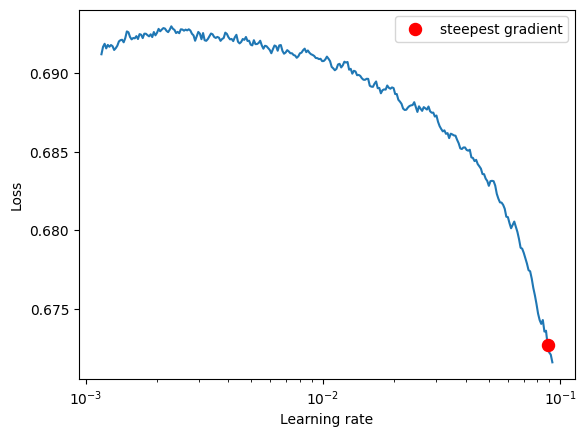

In [11]:
optimiser = optim.SGD(model.parameters(), lr = 0.001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=0.1, num_iter=300)

lr_finder.plot()
lr_finder.reset()

In [13]:
optimiser = optim.SGD(model.parameters(), lr = 8.84E-02)

## Metrics

In [14]:
metric = BinaryF1Score().to(device)

## Train and test the model

In [15]:
def train_test_loop(model, train_dataloader, test_dataloader, num_epochs = 100, save_prefix = "mumu_", verbose = False):
    # Save F1 scores and best model
    all_train_f1_scores = []
    all_test_f1_scores = []
    best_model = None
    candidate_f1_score = 0.0
    save_path = "fallback.pt"
    
    for epoch in tqdm(range(num_epochs)):
        # Training loop
        f1_scores = []
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            # Load the inputs
            inputs, labels = data
            inputs = torch.Tensor(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
                        
            # Forward + Backward + Optimise
            optimiser.zero_grad()
            outputs = model(inputs)
            outputs = torch.Tensor(outputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            
            # Training metrics calculation
            output_classes = torch.argmax(outputs, dim = 1)
            output_classes = torch.Tensor(output_classes).to(device)
            f1_score = metric(output_classes, labels)
            f1_scores.append(f1_score)
            
        # Update best scores and best model
        average_f1_score = (sum(f1_scores)/len(f1_scores))
        all_train_f1_scores.append(average_f1_score)
        if average_f1_score > candidate_f1_score:
            candidate_f1_score = average_f1_score
            average_f1_score_print = float(average_f1_score.cpu().detach())
            save_path = f"{save_prefix}_train_{str(average_f1_score_print).replace('.','_')}.pt"
            
        # Testing loop
        test_f1_scores = []
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                # Load the inputs
                inputs, labels = data
                inputs = torch.Tensor(inputs).to(device)
                labels = torch.Tensor(labels).to(device)

                # Forward
                outputs = model(inputs)
                outputs = torch.Tensor(outputs).to(device)
                output_classes = torch.argmax(outputs, dim = 1)
                output_classes = torch.Tensor(output_classes).to(device)
                
                # Testing metrics calculation
                f1_score = metric(output_classes, labels)
                test_f1_scores.append(f1_score)
            average_test_f1_score = (sum(test_f1_scores)/len(test_f1_scores))
            all_test_f1_scores.append(average_test_f1_score)
            
        
        # Verbose output if warranted
        if verbose:
            current_train_f1_score = all_train_f1_scores[-1]
            current_test_f1_score = all_test_f1_scores[-1]
            print(f"Train F1: {current_train_f1_score}, Test F1: {current_test_f1_score}")
        
    # Save best model at the end of the training loop
    torch.save(model.state_dict(), save_path)

In [16]:
TRAIN_ARGS = {
    "model" : model,
    "train_dataloader" : train_dataloader,
    "test_dataloader" : test_dataloader,
    "num_epochs" : 50,
    "save_prefix" : "mumu_regnet_800mf",
    "verbose" : True
}

In [17]:
train_test_loop(**TRAIN_ARGS)

  2%|▏         | 1/50 [00:03<02:58,  3.64s/it]

Train F1: 0.014495798386633396, Test F1: 0.0


  4%|▍         | 2/50 [00:07<02:47,  3.48s/it]

Train F1: 0.06424352526664734, Test F1: 0.0


  6%|▌         | 3/50 [00:10<02:43,  3.47s/it]

Train F1: 0.09386303275823593, Test F1: 0.0


  8%|▊         | 4/50 [00:13<02:37,  3.43s/it]

Train F1: 0.1851348578929901, Test F1: 0.06744598597288132


 10%|█         | 5/50 [00:17<02:32,  3.40s/it]

Train F1: 0.262127548456192, Test F1: 0.23909074068069458


 12%|█▏        | 6/50 [00:20<02:30,  3.43s/it]

Train F1: 0.21493589878082275, Test F1: 0.22079774737358093


 14%|█▍        | 7/50 [00:24<02:30,  3.50s/it]

Train F1: 0.2619684338569641, Test F1: 0.29847389459609985


 16%|█▌        | 8/50 [00:27<02:24,  3.44s/it]

Train F1: 0.33780553936958313, Test F1: 0.4761921763420105


 18%|█▊        | 9/50 [00:31<02:20,  3.43s/it]

Train F1: 0.42568451166152954, Test F1: 0.57292640209198


 20%|██        | 10/50 [00:34<02:18,  3.47s/it]

Train F1: 0.425752729177475, Test F1: 0.757847785949707


 22%|██▏       | 11/50 [00:38<02:14,  3.45s/it]

Train F1: 0.537600040435791, Test F1: 0.8066662549972534


 24%|██▍       | 12/50 [00:41<02:09,  3.41s/it]

Train F1: 0.6030496954917908, Test F1: 0.8095213174819946


 26%|██▌       | 13/50 [00:44<02:04,  3.38s/it]

Train F1: 0.704336404800415, Test F1: 0.8096909523010254


 28%|██▊       | 14/50 [00:48<02:02,  3.39s/it]

Train F1: 0.775327205657959, Test F1: 0.7989625334739685


 30%|███       | 15/50 [00:51<01:59,  3.40s/it]

Train F1: 0.7468499541282654, Test F1: 0.8256508111953735


 32%|███▏      | 16/50 [00:55<01:57,  3.45s/it]

Train F1: 0.7777027487754822, Test F1: 0.797024667263031


 34%|███▍      | 17/50 [00:58<01:52,  3.41s/it]

Train F1: 0.8127610683441162, Test F1: 0.8004615306854248


 36%|███▌      | 18/50 [01:01<01:49,  3.44s/it]

Train F1: 0.8363053798675537, Test F1: 0.8015294075012207


 38%|███▊      | 19/50 [01:05<01:46,  3.42s/it]

Train F1: 0.8278341293334961, Test F1: 0.8130518198013306


 40%|████      | 20/50 [01:08<01:42,  3.40s/it]

Train F1: 0.8225670456886292, Test F1: 0.8084834814071655


 42%|████▏     | 21/50 [01:11<01:38,  3.40s/it]

Train F1: 0.8423047661781311, Test F1: 0.819471001625061


 44%|████▍     | 22/50 [01:15<01:36,  3.44s/it]

Train F1: 0.8214113116264343, Test F1: 0.8072072267532349


 46%|████▌     | 23/50 [01:18<01:33,  3.44s/it]

Train F1: 0.8465610146522522, Test F1: 0.7989382147789001


 48%|████▊     | 24/50 [01:22<01:29,  3.44s/it]

Train F1: 0.8464862704277039, Test F1: 0.8344911932945251


 50%|█████     | 25/50 [01:25<01:26,  3.45s/it]

Train F1: 0.8629711270332336, Test F1: 0.8274437785148621


 52%|█████▏    | 26/50 [01:29<01:22,  3.45s/it]

Train F1: 0.8560951948165894, Test F1: 0.8340848684310913


 54%|█████▍    | 27/50 [01:32<01:18,  3.43s/it]

Train F1: 0.8765907883644104, Test F1: 0.8238099813461304


 56%|█████▌    | 28/50 [01:36<01:14,  3.39s/it]

Train F1: 0.8837601542472839, Test F1: 0.8256203532218933


 58%|█████▊    | 29/50 [01:39<01:10,  3.38s/it]

Train F1: 0.8775100708007812, Test F1: 0.8205184936523438


 60%|██████    | 30/50 [01:42<01:07,  3.36s/it]

Train F1: 0.8674802780151367, Test F1: 0.8294243812561035


 62%|██████▏   | 31/50 [01:46<01:04,  3.38s/it]

Train F1: 0.8742809295654297, Test F1: 0.8214294910430908


 64%|██████▍   | 32/50 [01:49<01:01,  3.40s/it]

Train F1: 0.8759021162986755, Test F1: 0.8269321918487549


 66%|██████▌   | 33/50 [01:52<00:57,  3.39s/it]

Train F1: 0.8948721885681152, Test F1: 0.8355602025985718


 68%|██████▊   | 34/50 [01:56<00:54,  3.41s/it]

Train F1: 0.8835524320602417, Test F1: 0.8367395401000977


 70%|███████   | 35/50 [01:59<00:51,  3.43s/it]

Train F1: 0.8951234221458435, Test F1: 0.840583324432373


 72%|███████▏  | 36/50 [02:03<00:48,  3.43s/it]

Train F1: 0.8744444847106934, Test F1: 0.8463399410247803


 74%|███████▍  | 37/50 [02:06<00:44,  3.42s/it]

Train F1: 0.9142282605171204, Test F1: 0.8288449645042419


 76%|███████▌  | 38/50 [02:10<00:41,  3.45s/it]

Train F1: 0.901490330696106, Test F1: 0.8403959274291992


 78%|███████▊  | 39/50 [02:13<00:37,  3.41s/it]

Train F1: 0.8949158191680908, Test F1: 0.8221632838249207


 80%|████████  | 40/50 [02:16<00:33,  3.38s/it]

Train F1: 0.9063634872436523, Test F1: 0.8383750915527344


 82%|████████▏ | 41/50 [02:20<00:30,  3.36s/it]

Train F1: 0.9202125072479248, Test F1: 0.8316082954406738


 84%|████████▍ | 42/50 [02:23<00:26,  3.36s/it]

Train F1: 0.8995864987373352, Test F1: 0.8430570960044861


 86%|████████▌ | 43/50 [02:26<00:23,  3.36s/it]

Train F1: 0.9120422601699829, Test F1: 0.8364068269729614


 88%|████████▊ | 44/50 [02:30<00:20,  3.38s/it]

Train F1: 0.9166749119758606, Test F1: 0.8357534408569336


 90%|█████████ | 45/50 [02:33<00:16,  3.37s/it]

Train F1: 0.914612352848053, Test F1: 0.812628984451294


 92%|█████████▏| 46/50 [02:37<00:13,  3.37s/it]

Train F1: 0.9070480465888977, Test F1: 0.8469810485839844


 94%|█████████▍| 47/50 [02:40<00:10,  3.36s/it]

Train F1: 0.9256360530853271, Test F1: 0.8303653597831726


 96%|█████████▌| 48/50 [02:43<00:06,  3.34s/it]

Train F1: 0.9034019112586975, Test F1: 0.8252938985824585


 98%|█████████▊| 49/50 [02:46<00:03,  3.33s/it]

Train F1: 0.9209798574447632, Test F1: 0.8167639970779419


100%|██████████| 50/50 [02:50<00:00,  3.40s/it]

Train F1: 0.9208774566650391, Test F1: 0.8435722589492798
